In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv("C:/Users/HP/Desktop/beadandó/train.csv")
test_data = pd.read_csv("C:/Users/HP/Desktop/beadandó/test.csv")


if set(train_data.columns) == set(test_data.columns):

    combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
def split_data(data):

    shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)


    train_data, test_data = train_test_split(shuffled_data, test_size=0.2, random_state=42)


    missing_values = shuffled_data.isnull().any(axis=1)


    blind_data = shuffled_data[missing_values]


    train_data = train_data.dropna()
    test_data = test_data.dropna()

    return train_data, test_data, blind_data


combined_data = pd.concat([train_data, test_data], ignore_index=True)


train_set, test_set, blind_set = split_data(combined_data)


print("Train set size:", len(train_set))
print("Test set size:", len(test_set))
print("Blind set size:", len(blind_set))

Train set size: 394
Test set size: 86
Blind set size: 501


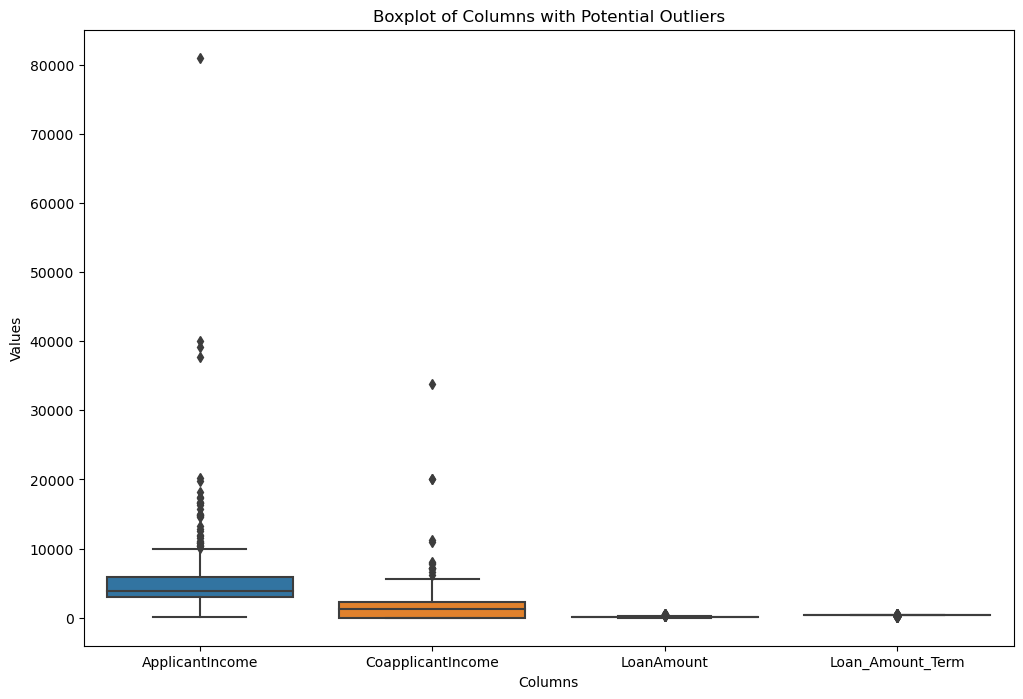

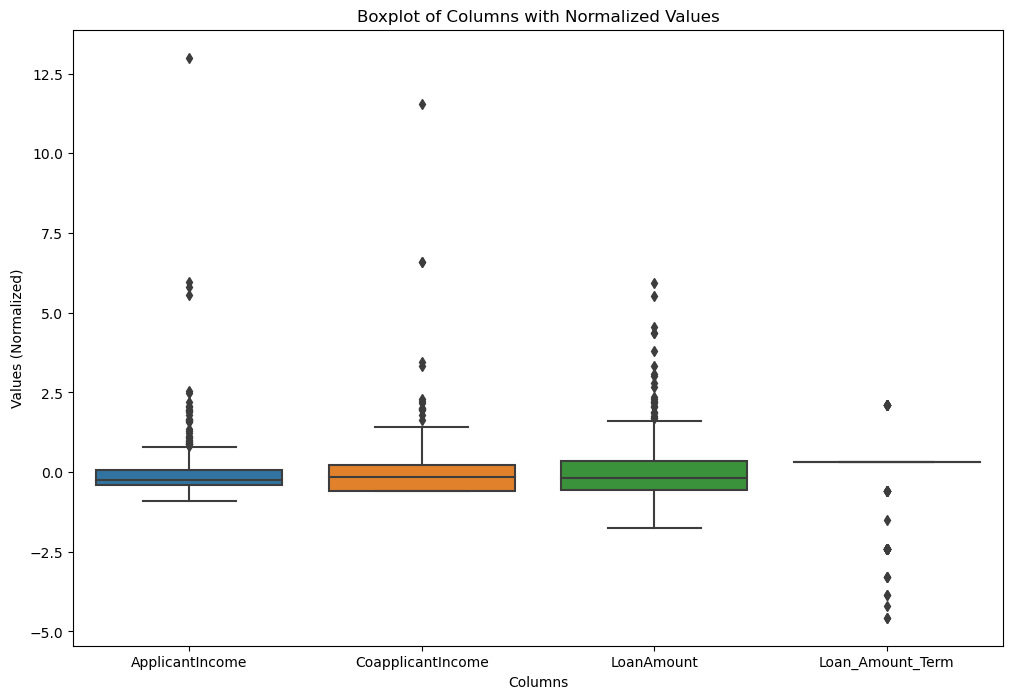

In [ ]:
outlier_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


plt.figure(figsize=(12, 8))
sns.boxplot(data=train_set[outlier_columns])
plt.title('Boxplot of Columns with Potential Outliers')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()


scaler = StandardScaler()
train_set[outlier_columns] = scaler.fit_transform(train_set[outlier_columns])
test_set[outlier_columns] = scaler.transform(test_set[outlier_columns])
blind_set[outlier_columns] = scaler.transform(blind_set[outlier_columns])


plt.figure(figsize=(12, 8))
sns.boxplot(data=train_set[outlier_columns])
plt.title('Boxplot of Columns with Normalized Values')
plt.xlabel('Columns')
plt.ylabel('Values (Normalized)')
plt.show()

In [ ]:
print(blind_set.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [ ]:
blind_set['Loan_ID'] = blind_set['Loan_ID'].fillna(train_set['Loan_ID'])
blind_set['Gender'] = blind_set['Gender'].fillna(train_set['Gender'])

In [ ]:
blind_set.Gender.fillna('Male', inplace = True)

In [ ]:
for column in blind_set.columns:
    if blind_set[column].isnull().sum() > 0:  # Ellenőrizzük, hogy az oszlopban vannak-e hiányzó értékek
        if blind_set[column].dtype == 'float64' or blind_set[column].dtype == 'int64':
            blind_set[column].fillna(blind_set[column].mean(), inplace=True)  # Hiányzó értékek átlaggal kitöltése
        else:
            blind_set[column].fillna(blind_set[column].mode()[0], inplace=True)  # Hiányzó értékek leggyakoribb értékkel kitöltése


In [ ]:
blind_set.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [ ]:
def classification_model(model, data, predictors, outcome):
    model.fit(data[predictors], data[outcome])
    predictions = model.predict(data[predictors])
    accuracy = metrics.accuracy_score(predictions, data[outcome])
    print("Accuracy: %s" % "{0:.3%}".format(accuracy))

    kf = KFold(n_splits = 5)
    error = []

    for blind_set, test in kf.split(data):
        blind_predictors = (data[predictors].iloc[blind_set, :])
        blind_target = (data[outcome].iloc[blind_set])
        model.fit(blind_predictors, blind_target)
        error.append(model.score(data[predictors].iloc[test, :], data[outcome].iloc[test]))

    print("Cross-Validation score: %s" % "{0:.3%}".format(np.mean(error)))


    model.fit(data[predictors], data[outcome])

In [ ]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, blind_set, predictor_var, outcome_var)

Accuracy: 91.218%
Cross-Validation score: 91.226%


In [ ]:
blind_set.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
 var_mod = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed'
,'Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    blind_set[i] = le.fit_transform(blind_set[i])
blind_set.dtypes


Loan_ID               object
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int32
dtype: object

In [ ]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History', 'Gender', 'Married', 'Education']
classification_model(model, blind_set, predictor_var, outcome_var)

Accuracy: 91.617%
Cross-Validation score: 91.426%


In [ ]:
model = RandomForestClassifier(n_estimators = 100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'Loan_Amount_Term',
'Credit_History', 'Property_Area']
classification_model(model, blind_set, predictor_var, outcome_var)


Accuracy: 95.010%
Cross-Validation score: 89.826%
